# Tutorial - Implementing a custom analysis block in Lightwood


## Introduction

As you might already know, Lightwood is designed to be a flexible machine learning (ML) library that is able to abstract and automate the entire ML pipeline. Crucially, it is also designed to be extended or modified very easily according to your needs, essentially offering the entire spectrum between fully automated AutoML and a lightweight wrapper for customized ML pipelines.

As such, we can identify several different customizable "phases" in the process. The relevant phase for this tutorial is the "analysis" that comes after a predictor has been trained. The goal of this phase is to generate useful insights, like accuracy metrics, confusion matrices, feature importance, etc. These particular examples are all included in the core analysis procedure that Lightwood executes.

However, the analysis procedure is structured into a sequential execution of "analysis blocks". Each analysis block should generate a well-defined set of insights, as well as handling any actions regarding these at inference time.

As an example, one of the core blocks is the Inductive Conformal Prediction (`ICP`) block, which handles the confidence estimation of all Lightwood predictors. The logic within can be complex at times, but thanks to the block abstraction we can deal with it in a structured manner. As this `ICP` block is used when generating predictions, it implements the two main methods that the `BaseAnalysisBlock` class specifies: `.analyze()` to setup everything that is needed, and `.explain()` to actually estimate the confidence in any given prediction.


## Objective

In this tutorial, we will go through the steps required to implement your own analysis blocks to customize the insights of any Lightwood predictor!

In particular, we will implement a "model correlation heatmap" block: we want to compare the predictions of all mixers inside a `BestOf` ensemble object, to understand how they might differ in their overall behavior.

In [1]:
from typing import Dict, Tuple
import pandas as pd
import lightwood
lightwood.__version__

INFO:lightwood-2307:No torchvision detected, image helpers not supported.
INFO:lightwood-2307:No torchvision/pillow detected, image encoder not supported
/opt/hostedtoolcache/Python/3.9.15/x64/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/hostedtoolcache/Python/3.9.15/x64/lib/python3.9/site-packages/gluonts/model/deepar/__init__.py:18: FutureWarning: The module gluonts.model.deepar has been moved to gluonts.mx.model.deepar. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import DeepAREstimator'.
  warnings.warn(


'22.12.1.0'

## Step 1: figuring out what we need

When designing an analysis block, an important choice needs to be made: will this block operate when calling the predictor? Or is it only going to describe its performance once in the held-out validation dataset?

Being in the former case means we need to implement both `.analyze()` and `.explain()` methods, while the latter case only needs an `.analyze()` method. Our `ModelCorrelationHeatmap` belongs to this second category.

Let's start the implementation by inheriting from `BaseAnalysisBlock`:

In [2]:
from lightwood.analysis import BaseAnalysisBlock

class ModelCorrelationHeatmap(BaseAnalysisBlock):
    def __init__(self, deps=tuple()):
        super().__init__(deps=deps)
        
    def analyze(self, info: Dict[str, object], **kwargs) -> Dict[str, object]:
        return info

    def explain(self,
                row_insights: pd.DataFrame,
                global_insights: Dict[str, object], **kwargs) -> Tuple[pd.DataFrame, Dict[str, object]]:
        
        return row_insights, global_insights

In [3]:
ModelCorrelationHeatmap()

Right now, our newly created analysis block doesn't do much, apart from returning the `info` and insights (`row_insights` and `global_insights`) exactly as it received them from the previous block.

As previously discussed, we only need to implement a procedure that runs post-training, no action is required at inference time. This means we can use the default `.explain()` behavior in the parent class:

In [4]:
class ModelCorrelationHeatmap(BaseAnalysisBlock):
    def __init__(self, deps=tuple()):
        super().__init__(deps=deps)
        
    def analyze(self, info: Dict[str, object], **kwargs) -> Dict[str, object]:
        return info

## Step 2: Implementing the custom analysis block

Okay, now for the fun bit: we have to implement a correlation heatmap between the predictions of all mixers inside a `BestOf` ensemble. This is currently the only ensemble implemented in Lightwood, but it is a good idea to explicitly check that the type of the ensemble is what we expect.

A natural question to ask at this point is: what information do we have to implement the procedure? You'll note that, apart from the `info` dictionary, we receive a `kwargs` dictionary. You can check out the full documentation for more details, but the keys (and respective value types) exposed in this object by default are:

In [5]:
kwargs = {
        'predictor': 'lightwood.ensemble.BaseEnsemble',
        'target': 'str',
        'input_cols': 'list',
        'dtype_dict': 'dict',
        'normal_predictions': 'pd.DataFrame',
        'data': 'pd.DataFrame',
        'train_data': 'lightwood.data.encoded_ds.EncodedDs',
        'encoded_val_data': 'lightwood.data.encoded_ds.EncodedDs',
        'is_classification': 'bool',
        'is_numerical': 'bool',
        'is_multi_ts': 'bool',
        'stats_info': 'lightwood.api.types.StatisticalAnalysis',
        'ts_cfg': 'lightwood.api.types.TimeseriesSettings',
        'accuracy_functions': 'list',
        'has_pretrained_text_enc': 'bool'
}

As you can see there is lots to work with, but for this example we will focus on using:

1. The `predictor` ensemble
2. The `encoded_val_data` to generate predictions for each mixer inside the ensemble

And the insight we're want to produce is a matrix that compares the output of all mixers and computes the correlation between them.

Let's implement the algorithm:

In [6]:
%%writefile model_correlation.py

from typing import Dict
from types import SimpleNamespace

import numpy as np

from lightwood.ensemble import BestOf
from lightwood.analysis import BaseAnalysisBlock


class ModelCorrelationHeatmap(BaseAnalysisBlock):
    def __init__(self, deps=tuple()):
        super().__init__(deps=deps)
        
    def analyze(self, info: Dict[str, object], **kwargs) -> Dict[str, object]:
        ns = SimpleNamespace(**kwargs)
        
        # only triggered with the right type of ensemble
        if isinstance(ns.predictor, BestOf):
            
            # store prediction from every mixer
            all_predictions = []

            for mixer in ns.predictor.mixers:
                predictions = mixer(ns.encoded_val_data)['prediction'].values  # retrieve np.ndarray from the returned pd.DataFrame
                all_predictions.append(predictions.flatten().astype(int))  # flatten and cast labels to int

            # calculate correlation matrix
            corrs = np.corrcoef(np.array(all_predictions))
            
            # save inside `info` object
            info['mixer_correlation'] = corrs
        
        return info


Writing model_correlation.py


Notice the use of `SimpleNamespace` for dot notation accessors.

The procedure above is fairly straightforward, as we leverage numpy's `corrcoef()` function to generate the matrix. 

Finally, it is very important to add the output to `info` so that it is saved inside the actual predictor object. 

## Step 3: Exposing the block to Lightwood


To use this in an arbitrary script, we need to add the above class (and all necessary imports) to a `.py` file inside one of the following directories:

* `~/lightwood_modules` (where `~` is your home directory, e.g. `/Users/username/` for macOS and `/home/username/` for linux
* `/etc/lightwood_modules`

Lightwood will scan these directories and import any class so that they can be found and used by the `JsonAI` code generating module.

**To continue, please save the code cell above as `model_correlation.py` in one of the indicated directories.**

## Step 4: Final test run

Ok! Everything looks set to try out our custom block. Let's generate a predictor for [this](https://github.com/mindsdb/lightwood/blob/stable/tests/data/hdi.csv) sample dataset, and see whether our new insights are any good.

First, it is important to add our `ModelCorrelationHeatmap` to the `analysis_blocks` attribute of the Json AI object that will generate your predictor code. 

In [7]:
from lightwood.api.high_level import ProblemDefinition, json_ai_from_problem, load_custom_module

# First, load the custom module we wrote
load_custom_module('model_correlation.py')

# read dataset
df = pd.read_csv('https://raw.githubusercontent.com/mindsdb/lightwood/stable/tests/data/hdi.csv')

# define the predictive task
pdef = ProblemDefinition.from_dict({
    'target': 'Development Index',         # column you want to predict
    'time_aim': 100,
})

# generate the Json AI intermediate representation from the data and its corresponding settings
json_ai = json_ai_from_problem(df, problem_definition=pdef)

# add the custom list of analysis blocks; in this case, composed of a single block
json_ai.analysis_blocks = [{
    'module': 'model_correlation.ModelCorrelationHeatmap',
    'args': {}
}]

INFO:type_infer-2307:Analyzing a sample of 222
INFO:type_infer-2307:from a total population of 225, this is equivalent to 98.7% of your data.
INFO:type_infer-2307:Infering type for: Population
INFO:type_infer-2307:Column Population has data type integer
INFO:type_infer-2307:Infering type for: Area (sq. mi.)
INFO:type_infer-2307:Column Area (sq. mi.) has data type integer
INFO:type_infer-2307:Infering type for: Pop. Density 
INFO:type_infer-2307:Column Pop. Density  has data type float
INFO:type_infer-2307:Infering type for: GDP ($ per capita)
INFO:type_infer-2307:Column GDP ($ per capita) has data type integer
INFO:type_infer-2307:Infering type for: Literacy (%)
INFO:type_infer-2307:Column Literacy (%) has data type float
INFO:type_infer-2307:Infering type for: Infant mortality 
INFO:type_infer-2307:Column Infant mortality  has data type float
INFO:type_infer-2307:Infering type for: Development Index
INFO:type_infer-2307:Column Development Index has data type categorical
INFO:dataprep_

We can take a look at the respective Json AI key just to confirm our newly added analysis block is in there:

In [8]:
json_ai.analysis_blocks

[{'module': 'model_correlation.ModelCorrelationHeatmap', 'args': {}}]

Now we are ready to create a predictor from this Json AI, and subsequently train it:

In [9]:
from lightwood.api.high_level import code_from_json_ai, predictor_from_code

code = code_from_json_ai(json_ai)
predictor = predictor_from_code(code)

predictor.learn(df)

INFO:dataprep_ml-2307:Unable to import black formatter, predictor code might be a bit ugly.
INFO:dataprep_ml-2307:[Learn phase 1/8] - Statistical analysis
INFO:dataprep_ml-2307:Starting statistical analysis
INFO:dataprep_ml-2307:Finished statistical analysis
DEBUG:lightwood-2307: `analyze_data` runtime: 0.02 seconds
INFO:dataprep_ml-2307:[Learn phase 2/8] - Data preprocessing
INFO:dataprep_ml-2307:Cleaning the data
DEBUG:lightwood-2307: `preprocess` runtime: 0.01 seconds
INFO:dataprep_ml-2307:[Learn phase 3/8] - Data splitting
INFO:dataprep_ml-2307:Splitting the data into train/test
DEBUG:lightwood-2307: `split` runtime: 0.02 seconds
INFO:dataprep_ml-2307:[Learn phase 4/8] - Preparing encoders
INFO:lightwood-2307:Done running for: Population
INFO:lightwood-2307:Done running for: Area (sq. mi.)
INFO:lightwood-2307:Done running for: Pop. Density 
INFO:lightwood-2307:Done running for: GDP ($ per capita)
INFO:lightwood-2307:Done running for: Literacy (%)
INFO:lightwood-2307:Done running fo

[15:19:26] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1


INFO:lightwood-2307:Loss of 1.8292739391326904 with learning rate 0.00014
INFO:lightwood-2307:Loss of 1.9874005317687988 with learning rate 0.00019599999999999997
INFO:lightwood-2307:Found learning rate of: 0.00014
INFO:lightwood-2307:Loss @ epoch 1: 1.5811586380004883
INFO:lightwood-2307:Loss @ epoch 2: 1.6478627920150757
INFO:lightwood-2307:Loss @ epoch 3: 1.6348984241485596
INFO:lightwood-2307:Loss @ epoch 4: 1.6213678121566772
INFO:lightwood-2307:Loss @ epoch 5: 1.606968641281128
INFO:lightwood-2307:Loss @ epoch 6: 1.5919418334960938
INFO:lightwood-2307:Loss @ epoch 7: 1.5534840822219849
INFO:lightwood-2307:Loss @ epoch 8: 1.5364340543746948
INFO:lightwood-2307:Loss @ epoch 9: 1.519599199295044
INFO:lightwood-2307:Loss @ epoch 10: 1.5030533075332642
INFO:lightwood-2307:Loss @ epoch 11: 1.4867080450057983
INFO:lightwood-2307:Loss @ epoch 12: 1.4707883596420288
INFO:lightwood-2307:Loss @ epoch 13: 1.4331672191619873
INFO:lightwood-2307:Loss @ epoch 14: 1.418662190437317
INFO:lightwoo

[0]	validation_0-mlogloss:0.87488


INFO:lightwood-2307:A single GBM iteration takes 0.1 seconds
INFO:lightwood-2307:Training XGBoost with 105 iterations given 13.180630761146546 seconds constraint


[0]	validation_0-mlogloss:0.87488
[1]	validation_0-mlogloss:0.60290
[2]	validation_0-mlogloss:0.42973
[3]	validation_0-mlogloss:0.31221
[4]	validation_0-mlogloss:0.22983
[5]	validation_0-mlogloss:0.17095
[6]	validation_0-mlogloss:0.12835
[7]	validation_0-mlogloss:0.09724
[8]	validation_0-mlogloss:0.07442
[9]	validation_0-mlogloss:0.05754
[10]	validation_0-mlogloss:0.04502
[11]	validation_0-mlogloss:0.03568
[12]	validation_0-mlogloss:0.02865
[13]	validation_0-mlogloss:0.02334
[14]	validation_0-mlogloss:0.01941
[15]	validation_0-mlogloss:0.01658
[16]	validation_0-mlogloss:0.01459
[17]	validation_0-mlogloss:0.01318
[18]	validation_0-mlogloss:0.01227
[19]	validation_0-mlogloss:0.01171
[20]	validation_0-mlogloss:0.01174
[21]	validation_0-mlogloss:0.01177
[22]	validation_0-mlogloss:0.01182
[23]	validation_0-mlogloss:0.01187


INFO:lightwood-2307:XGBoost mixer does not have a `partial_fit` implementation
DEBUG:lightwood-2307: `fit_mixer` runtime: 0.07 seconds
INFO:lightwood-2307:Started fitting RandomForest model
INFO:lightwood-2307:The number of trials (Optuna) is 20.
INFO:lightwood-2307:init_score: 0.0056968453264924146, optuna_score: 0.018231117962502003
INFO:lightwood-2307:RandomForest based correlation of (train data): 1.0
INFO:lightwood-2307:RandomForest based correlation of (dev data): 1.0
DEBUG:lightwood-2307: `fit_mixer` runtime: 17.52 seconds
INFO:dataprep_ml-2307:Ensembling the mixer
INFO:lightwood-2307:Mixer: Neural got accuracy: 0.894
INFO:lightwood-2307:Mixer: LightGBM got accuracy: 1.0
INFO:lightwood-2307:Mixer: XGBoostMixer got accuracy: 1.0
INFO:lightwood-2307:Mixer: RandomForest got accuracy: 1.0
INFO:lightwood-2307:Picked best mixer: RandomForest
DEBUG:lightwood-2307: `fit` runtime: 27.84 seconds
INFO:dataprep_ml-2307:[Learn phase 7/8] - Ensemble analysis
INFO:dataprep_ml-2307:Analyzing th

Finally, we can visualize the mixer correlation matrix:

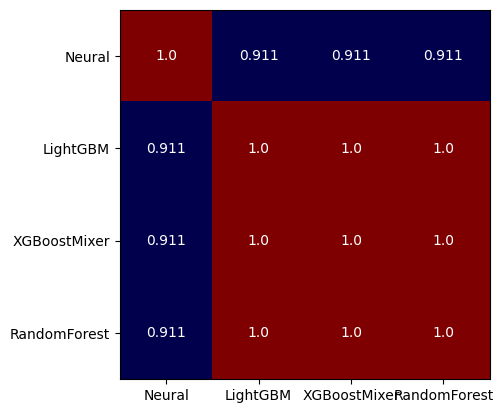

In [10]:
import matplotlib.pyplot as plt
import numpy as np

mc = predictor.runtime_analyzer['mixer_correlation']  # newly produced insight

mixer_names = [c.__class__.__name__ for c in predictor.ensemble.mixers]

# plotting code
fig, ax = plt.subplots()
im = ax.imshow(mc, cmap='seismic')

# set ticks
ax.set_xticks(np.arange(mc.shape[0]))
ax.set_yticks(np.arange(mc.shape[1]))

# set tick labels
ax.set_xticklabels(mixer_names)
ax.set_yticklabels(mixer_names)

# show cell values
for i in range(len(mixer_names)):
    for j in range(len(mixer_names)):
        text = ax.text(j, i, round(mc[i, j], 3), ha="center", va="center", color="w")


Nice! We've just added an additional piece of insight regarding the predictor that Lightwood came up with for the task of predicting the Human Development Index of any given country.

What this matrix is telling us is whether predictions of each pair of the mixers stored in the ensemble have a high correlation or not.

This is, of course, a very simple example, but it shows the convenience of such an abstraction within the broader pipeline that Lightwood automates.

For more complex examples, you can check out any of the three core analysis blocks that we use:

* `lightwood.analysis.nc.calibrate.ICP`
* `lightwood.analysis.helpers.acc_stats.AccStats`
* `lightwood.analysis.helpers.feature_importance.PermutationFeatureImportance`
